# 평가문항 - 상세기준

- 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.
  - 구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.
- Attentional Seq2seq 모델이 정상적으로 구동된다.
  - seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.
- 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
  - 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.

In [3]:
# 파일 저장 커스텀 모듈

import sys
sys.path.append("../custom")

from importlib import reload
import custom_utils
reload(custom_utils)

from custom_utils import save_var, load_var


In [4]:
import time
import re
import os
import io
import random

from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import tensorflow as tf
import matplotlib



In [5]:
print(pd.__version__)
print(tf.__version__)
print(matplotlib.__version__)

2.0.3
2.13.0
3.7.2


In [6]:
import konlpy
from konlpy import tag

# Step 2. 데이터 정제

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3. 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

> 모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. 
> cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

## data load

In [5]:
def read_raw(path):
    with open(path, "r") as f:
        raw = f.read().splitlines()

    print("Data Size:", len(raw))
    print("Example:")

    for sen in raw[0:100][::20]: print(">>", sen)
        
    return raw

In [8]:
path_ko = "./data/korean-english-park.train.ko"
path_en = "./data/korean-english-park.train.en"

In [11]:
raw_ko = read_raw(path_ko)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [13]:
save_var(raw_ko, "raw_ko")

In [12]:
raw_en = read_raw(path_en)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [14]:
save_var(raw_en, "raw_en")

In [7]:
raw_ko = load_var("raw_ko")
raw_en = load_var("raw_en")

## preprocess

In [8]:
def clean_en(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    return sentence

In [9]:
def clean_ko(text):
    try:
        pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
        text = re.sub(pattern=pattern, repl='', string=text)
        pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL제거
        text = re.sub(pattern=pattern, repl='', string=text)
        pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
        text = re.sub(pattern=pattern, repl='', string=text)
        pattern = '<[^>]*>'         # HTML 태그 제거
        text = re.sub(pattern=pattern, repl='', string=text)
        pattern = '[^\w\s\n]'         # 특수기호제거
        text = re.sub(pattern=pattern, repl='', string=text)
        text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', string=text)
        text = re.sub('\n', '.', string=text)
        return text 
    except TypeError:
        print("Warning: Input to clean_ko was not a string or bytes-like object.")
        print(text)
        return text  # or return '' if you want to return an empty string

In [10]:
def preprocess_sentence(sentence, clean_func, s_token=False, e_token=False):

    sentence = clean_func(sentence)
    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [11]:
enc_corpus = []
dec_corpus = []

for ko, en in zip(raw_ko, raw_en):
    if len(ko.split()) > 40: continue
    enc_corpus.append(preprocess_sentence(ko, clean_ko))
    dec_corpus.append(preprocess_sentence(en, clean_en, s_token=True, e_token=True))

print(len(enc_corpus))
print("Korean:", enc_corpus[100])

print(len(dec_corpus))
print("English:", dec_corpus[100])

93988
Korean: 1960만갤론 이상의 중유를 운반하던 손상된 유조선이 스페인 북서부 연안 130마일 해역에서 침몰하여 스페인 당국이 어업이 주요 산업인 이 지역에서 해안선 보호를 위해 황급히 서두르고 있다
93988
English: <start> carrying more than . million gallons of heavy fuel oil sank miles off spain s northwest coast , leaving spanish authorities scrambling to protect the coastline in the region where fishing is the primary industry . <end>


In [204]:
len(enc_corpus), len(dec_corpus)

(24531, 24531)

In [12]:
postfix = "14_desktop"

In [13]:
save_var(enc_corpus, f"enc_corpus_{postfix}")
save_var(dec_corpus, f"dec_corpus_{postfix}")

## sentence length

In [20]:
def show_length(corpus, bins=40):
    length = [len(sentence) for sentence in corpus]
    plt.figure(figsize=(4,4))
    plt.hist(length, bins=bins)
    return length

In [15]:
enc_length = [len(sentence.split()) for sentence in enc_corpus]
dec_length = [len(sentence.split()) for sentence in dec_corpus]

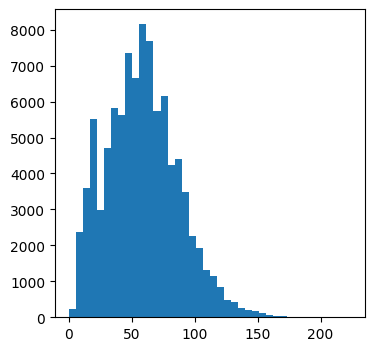

In [21]:
res = show_length(enc_corpus)

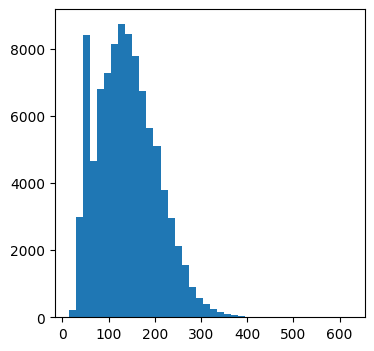

In [22]:
res = show_length(dec_corpus)

In [23]:
enc_corpus_filtered = []
dec_corpus_filtered = []

for enc, dec in zip(enc_corpus, dec_corpus):
    if len(enc.split()) < 3: print(enc, end=', '); continue
    enc_corpus_filtered.append(enc)
    dec_corpus_filtered.append(dec)

어휘, 어휘, 어휘, 낙태는 불법이다, 모르고 있습니다, 네 보이는군요, 디즈니사만이 아니다, 유럽에서도 마찬가지이다, 어휘, 이것이 사실일까요, 어휘, 오차범위는 없었다, 어휘, 어휘, 번역, 어휘, 번역, 어휘, 번역, 번역, 어휘, 번역, 어휘, 번역, 하루에 13번, 어휘, 외딴 곳, 어휘, 3월 안경, 번역, 번역, 번역, 어휘, 번역, 어휘, 어휘, 번역, 어휘, 번역, 어휘, 번역, 어휘, 번역, 어휘, 번역, 번역, 1, 2, 3, 4, 향년 71세였다, 4 소물리에, 7오탈자 미확인, 면접, 11지각, 면접 이후, 캐주얼 스타일, 남자들, 가족, 행복의 역설, 충분한 수면, 순간순간을 즐기기, 3 판매원, 4 구조대원, 음식, 햇빛, 보조식품, 계획을 세운다, 5어미니의 실수, 장소, 판매 제품, 판매 제품, 과일, 3 견과류, 양파, 코브, 코브, 산부인과, 심장질환, 유방암, 백일해 백신, 수두 백신, 바리백스Varivax, 대상포진, 조스타백스Zostavax, 홍역 이하선염, MMR, 여행자의 질병, B형간염, 노동의 붕괴, , Q, articlecnn_earticleaspcat_code22Total_ID3108483 1, 햇볕 쬐기, 3 자원봉사, 7 지압, 10 숙면, 첫인상, 세부사항, 웹사이트 wwwsolealbiscioneit, 첫인상, 세부사항, 첫인상, 세부사항, 웹사이트 wwwhoteltrasteverehouseit, 하나의 꿈, 비즈니스다, 향초를 피운다, 4, 6, 거울을 세운다, 친절하게 대화한다, 신생아, 생후 24개월까지, WASHINGTON CNN권성근JOINS, articlecnn_earticleaspcat_code22Total_ID3078112, 공기가 희박하다, 판결은 연기됐다, articlecnn_earticleaspcat_code22Total_ID3065258, 마우이Maui 하와이주, articlecnn_earticleaspcat_code22Total_ID3053480, MOSCOW CNN권성근JOINS

> 한 단어로 이루어진 문장들이, 그것도 중복된 데이터들이 섞여있다.  
> 제거!  

In [207]:
enc_corpus = enc_corpus_filtered
dec_corpus = dec_corpus_filtered

enc_corpus_filtered = []
dec_corpus_filtered = []

for enc, dec in zip(enc_corpus, dec_corpus):
    if len(dec.split()) > 150: continue
    enc_corpus_filtered.append(enc)
    dec_corpus_filtered.append(dec)

In [208]:
len(enc_corpus_filtered), len(dec_corpus_filtered)

(23526, 23526)

In [95]:
postfix = "07_rm_dot"

In [117]:
save_var(enc_corpus_filtered, f"enc_corpus_{postfix}")
save_var(dec_corpus_filtered, f"dec_corpus_{postfix}")

# Step 3. 데이터 토큰화

> 앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요!    

> 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)    

> ❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

## mecab

In [9]:
def tokenize_ko_sentence(sentence, tokenizer, stopwords):
    tokenized_sentence = tokenizer.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    return stopwords_removed_sentence

In [10]:
def get_stopwords_ko():
    # 불용어 정의
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    return stopwords

In [11]:
def tokenize_ko(sentences, tokenizer):
    stopwords = get_stopwords_ko()
    tokenized_data = []
    for sentence in tqdm(sentences):
        tokenized_data.append(tokenize_ko_sentence(sentence, tokenizer, stopwords))
    return tokenized_data

In [23]:
mecab = tag.Mecab()

In [100]:
enc_corpus_tkn = tokenize_ko(sentences=enc_corpus_filtered, tokenizer=mecab)

100%|██████████| 23573/23573 [00:01<00:00, 18084.68it/s]


In [101]:
postfix = "07_rm_dot"

In [102]:
save_var(enc_corpus_tkn, f"enc_corpus_{postfix}")

In [103]:
enc_corpus_tkn = load_var(f"enc_corpus_{postfix}")

In [104]:
len(enc_corpus_tkn), len(dec_corpus_filtered)

(23573, 23573)

In [119]:
for index, (enc, enc_mecab, dec) in enumerate(zip(enc_corpus_filtered, enc_corpus_tkn, dec_corpus_filtered)):
    print(f"{index}: \t{enc} \n\t{enc_mecab} \n\t{dec}")
    if index > 20: break

0: 	개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 
	['개인', '용', '컴퓨터', '사용', '상당', '부분', '이것', '보다', '뛰어날', '수', '있', '느냐'] 
	<start> much of personal computing is about can you top this ? <end>
1: 	그러나 이것은 또한 책상도 필요로 하지 않는다 
	['그러나', '이것', '또한', '책상', '필요', '로', '하', '지', '않', '는다'] 
	<start> like all optical mice , but it also doesn t need a desk <end>
2: 	많은 인질들이 화학 가스의 영향으로 고통을 겪으며 병원으로 옮겨졌다 
	['많', '인질', '화학', '가스', '영향', '고통', '을', '겪', '으며', '병원', '옮겨졌', '다'] 
	<start> many captives were taken to hospital suffering from the effects of the chemical <end>
3: 	100여명의 사망자가 예상되는 베트남 빌딩 화재 
	['100', '여', '명', '사망자', '예상', '되', '베트남', '빌딩', '화재'] 
	<start> at least people have been confirmed dead but that figure is expected to rise , possibly to over <end>
4: 	그와 동시 에 노동 비용은 더욱 상승하고 있습니다 라고 말했다 
	['그', '동시', '노동', '비용', '더욱', '상승', '하', '고', '있', '습니다', '라고', '말', '했', '다'] 
	<start> at the same time , labor costs are more and more <end>
5: 	로보트 장치의 연간 판매액은 50억60억달러로 추산되고 있다 
	['로보트', '장치', '연간', 

## word2vec

In [25]:
from gensim.models import Word2Vec

### enc.

In [131]:
enc_w2v = Word2Vec(sentences = enc_corpus_tkn, 
               vector_size = 50, 
               window = 5, min_count = 5, workers = 4, sg = 0)

In [132]:
postfix

'07_rm_dot'

In [133]:
enc_w2v.save(f"enc_corpus_{postfix}.w2v")

In [94]:
enc_w2v.wv.vectors.shape

(4135, 50)

In [134]:
enc_w2v = Word2Vec.load(f"enc_corpus_{postfix}.w2v")

In [135]:
print(enc_w2v.wv.most_similar("도시"))

[('시장', 0.9908114075660706), ('회사', 0.9851050972938538), ('장', 0.9849457740783691), ('과정', 0.983531653881073), ('시위', 0.9834348559379578), ('이미', 0.9826364517211914), ('관광객', 0.9825882911682129), ('로마', 0.9825136065483093), ('율', 0.9815678000450134), ('계', 0.9811376333236694)]


### dec.

In [136]:
dec_corpus_split = [sentence.split() for sentence in dec_corpus_filtered]

In [137]:
dec_w2v = Word2Vec(sentences = dec_corpus_split, 
                   vector_size = 50, 
                   window = 5, min_count = 5, workers = 4, sg = 0)

In [138]:
dec_w2v.save(f"dec_corpus_{postfix}.w2v")

In [139]:
dec_w2v = Word2Vec.load(f"dec_corpus_{postfix}.w2v")

In [141]:
print(dec_w2v.wv.most_similar("top"))

[('body', 0.9772177934646606), ('son', 0.971909761428833), ('late', 0.9709904193878174), ('remains', 0.9650716781616211), ('head', 0.9634805917739868), ('web', 0.9630990028381348), ('team', 0.9624633193016052), ('stops', 0.9618635177612305), ('night', 0.9614982008934021), ('state', 0.9611568450927734)]


## tokenizer, embedding matrix

In [12]:
def get_tokenizer(corpus):
    print(len(corpus))
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    return tokenizer

In [13]:
def get_embedding_matrix(corpus, tokenizer, model_w2v, embedding_dim=300):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in model_w2v.wv:
            embedding_matrix[i] = model_w2v.wv[word]
    return embedding_matrix

In [210]:
enc_tokenizer = get_tokenizer(enc_corpus_filtered)

23526


In [176]:
enc_embedding_matrix = get_embedding_matrix(enc_corpus_tkn, 
                                        tokenizer=enc_tokenizer, 
                                        model_w2v=enc_w2v, 
                                        embedding_dim=50)

In [211]:
dec_tokenizer = get_tokenizer(dec_corpus_filtered)

23526


In [178]:
dec_embedding_matrix = get_embedding_matrix(dec_corpus_filtered, 
                                        tokenizer=dec_tokenizer, 
                                        model_w2v=dec_w2v, 
                                        embedding_dim=50)

## encoder/decoder tensor

In [14]:
def get_tensor(corpus, tokenizer):
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor

In [212]:
enc_tensor = get_tensor(enc_corpus_filtered, enc_tokenizer)
dec_tensor = get_tensor(dec_corpus_filtered, dec_tokenizer)

In [213]:
enc_tensor.shape, dec_tensor.shape

((23526, 12), (23526, 34))

In [146]:
save_var(enc_tokenizer, f"enc_tokenizer_{postfix}")
save_var(enc_tensor, f"enc_tensor_{postfix}")

save_var(dec_tokenizer, f"dec_tokenizer_{postfix}")
save_var(dec_tensor, f"dec_tensor_{postfix}")

In [172]:
postfix

'08_rm_w2v_ep03'

In [173]:
postfix = "07_rm_dot"

In [174]:
enc_tokenizer = load_var(f"enc_tokenizer_{postfix}")
enc_tensor = load_var(f"enc_tensor_{postfix}")

dec_tokenizer = load_var(f"dec_tokenizer_{postfix}")
dec_tensor = load_var(f"dec_tensor_{postfix}")

# Step 4. 모델 설계

> 한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 

> 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! 

> Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

## attention, encoder, decoder

In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [64]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.W_combine = tf.keras.layers.Dense(units)

    def call(self, H_encoder, H_decoder):
        print("[ H_encoder ] Shape:", H_encoder.shape)

        WH = self.W_combine(H_encoder)
        print("[ W_encoder X H_encoder ] Shape:", WH.shape)

        H_decoder = tf.expand_dims(H_decoder, 1)
        alignment = tf.matmul(WH, tf.transpose(H_decoder, [0, 2, 1]))
        print("[ Score_alignment ] Shape:", alignment.shape)

        attention_weights = tf.nn.softmax(alignment, axis=1)
        print("\n최종 Weight:\n", attention_weights.numpy())

        attention_weights = tf.squeeze(attention_weights, axis=-1)
        context_vector = tf.matmul(attention_weights, H_encoder)

        return context_vector, attention_weights


In [217]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, embedding_matrix=None):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#         self.embedding = tf.keras.layers.Embedding(
#             input_dim=vocab_size,
#             output_dim=embedding_dim,
#             embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
#             trainable=True)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [218]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, embedding_matrix=None):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#         self.embedding = tf.keras.layers.Embedding(
#             input_dim=vocab_size,
#             output_dim=embedding_dim,
#             embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
#             trainable=True)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        #self.attention = LuongAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

## build model

In [219]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512
# embedding_dim = 50

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)
# encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units, enc_embedding_matrix)
# decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units, dec_embedding_matrix)

# sample input
# sequence_len = 30
sequence_len = 50

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 50, 1024)
Decoder Output: (64, 15496)
Decoder Hidden State: (64, 1024)
Attention: (64, 50, 1)


## optimizer, loss

In [220]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)


## train_step

In [221]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

# Step 5. 훈련하기

> 훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 

> 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요!   
> (Attention Map을 시각화해보는 것도 재밌을 거예요!)

> ❕ 참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

## 예문 ##
K1) 오바마는 대통령이다.  
K2) 시민들은 도시 속에 산다.  
K3) 커피는 필요 없다.  
K4) 일곱 명의 사망자가 발생했다.  

## 제출 ##
E1) obama is the president . <end>  
E2) people are victims of the city . <end>  
E2) the price is not enough . <end>  
E2) seven people have died . <end>  

## train

In [186]:
def train_epoch(epochs, enc_tensor, dec_tensor, encoder, decoder, 
                optimizer, dec_tokenizer, batch_size):

    history = []

    for epoch in range(epochs):
        total_loss = 0

        idx_list = list(range(0, enc_tensor.shape[0], batch_size))
        random.shuffle(idx_list)
        t = tqdm(idx_list, desc=f"Epoch {epoch+1}", position=0, leave=True)

        for (batch, idx) in enumerate(t):
            batch_loss = train_step(enc_tensor[idx:idx+batch_size],
                                    dec_tensor[idx:idx+batch_size],
                                    encoder,
                                    decoder,
                                    optimizer,
                                    dec_tokenizer)

            total_loss += batch_loss
            t.set_postfix_str(f"Loss: {total_loss.numpy() / (batch + 1):.4f}")

        history.append(total_loss)

    return history

In [222]:
BATCH_SIZE = 512
EPOCHS = 10
history = train_epoch(EPOCHS, 
                      enc_tensor, dec_tensor, 
                      encoder, decoder, 
                      optimizer, 
                      dec_tokenizer, 
                      BATCH_SIZE)

Epoch 10: 100%|██████████| 46/46 [00:56<00:00,  1.22s/it, Loss: 1.4395]


In [223]:
postfix = "08_no-w2v_ep10"

In [ ]:
encoder.save(f"encoder_{postfix}", save_format="tf")
decoder.save(f"decoder_{postfix}", save_format="tf")

In [224]:
encoder.save_weights(f"encoder_{postfix}.ckpt")
decoder.save_weights(f"decoder_{postfix}.ckpt")

In [43]:
histories = {}

In [225]:
histories[postfix] = history

In [226]:
save_var(histories, "histories")

## evaluate

In [48]:
def evaluate_preprocess_tkn(sentence):
    sentence = preprocess_sentence(sentence, clean_ko)
    print(sentence)
    sentence = tokenize_ko_sentence(sentence, mecab, get_stopwords_ko())
    print(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    print(inputs)
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')
    print(inputs.shape, inputs)
    return inputs

In [49]:
def evaluate_preprocess(sentence):
    sentence = preprocess_sentence(sentence, clean_ko)
    print(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    print(inputs)
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')
    print(inputs.shape, inputs)
    return inputs

In [50]:
def evaluate(sentence, encoder, decoder, preprocess_func):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    inputs = preprocess_func(sentence)

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [51]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    plt.rc('font', family='NanumGothic')
    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [52]:
def translate(sentence, encoder, decoder, preprocess_func):
    result, sentence, attention = evaluate(sentence, encoder, decoder, preprocess_func)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

In [53]:
def translate_tkn(sentence, encoder, decoder, preprocess_func):
    result, sentence, attention = evaluate(sentence, encoder, decoder, preprocess_func)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

In [54]:
def test_translate(sentences):
    for sentence in sentences:
        translate(sentence, encoder, decoder, evaluate_preprocess)

In [55]:
def test_translate_tkn(sentences):
    for sentence in sentences:
        translate_tkn(sentence, encoder, decoder, evaluate_preprocess_tkn)

In [56]:
test_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다.",
]

## 시각화 - Loss

In [253]:
loss = []
for item in histories[postfix]:
    loss.append(item.numpy())

In [256]:
loss_value = np.array(loss)

In [269]:
res = loss_value / round(enc_tensor.shape[0] / BATCH_SIZE)

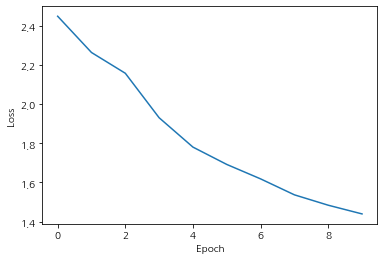

In [272]:
plt.plot(res)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 번역 테스트

### 첫번째 시도 - 기본 구성

Input: 오바마는 대통령이다
Predicted translation: korea to lopez , too . <end> 


/tmp/ipykernel_37/3492739089.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_37/3492739089.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


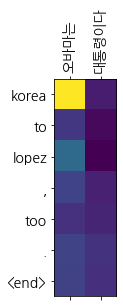

Input: 시민들은 도시 속에 산다
Predicted translation: they could be reduced <end> 


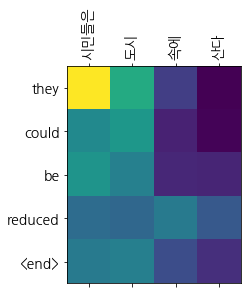

Input: 커피는 필요 없다
Predicted translation: living in a cage in hong kong <end> 


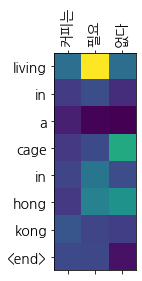

Input: 일곱 명의 사망자가 발생했다
Predicted translation: it s a lot of american classic . <end> 


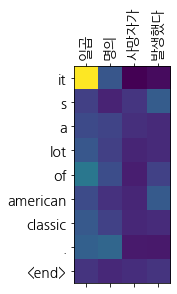

In [110]:
test_translate(test_sentences)

> 첫번째 시도, 기본 구성  
> 전혀... 말도 안되는 번역이다.

### 두번째 시도 - mecab 으로 한글 토큰화

오바마는 대통령이다
['오바마', '대통령', '다']
[[301, 81, 1]]
(1, 12) [[301  81   1   0   0   0   0   0   0   0   0   0]]
Input: 오바마는 대통령이다.
Predicted translation: the flu ? <end> 


/tmp/ipykernel_37/3492739089.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_37/3492739089.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


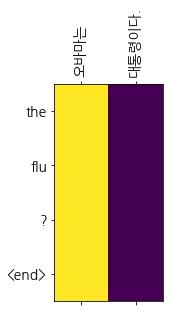

시민들은 도시 속에 산다
['시민', '도시', '속', '산다']
[[1123, 323, 420]]
(1, 12) [[1123  323  420    0    0    0    0    0    0    0    0    0]]
Input: 시민들은 도시 속에 산다.
Predicted translation: the flu ? . . . . . . . . . . . . 


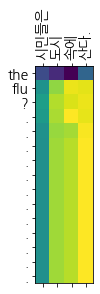

커피는 필요 없다
['커피', '필요', '없', '다']
[[1296, 219, 32, 1]]
(1, 12) [[1296  219   32    1    0    0    0    0    0    0    0    0]]
Input: 커피는 필요 없다.
Predicted translation: the flu ? . . . . . . . . . . . . 


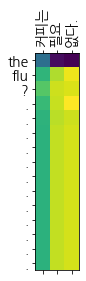

일곱 명의 사망자가 발생했다
['일곱', '명', '사망자', '발생', '했', '다']
[[6995, 15, 360, 122, 3, 1]]
(1, 12) [[6995   15  360  122    3    1    0    0    0    0    0    0]]
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the flu ? <end> 


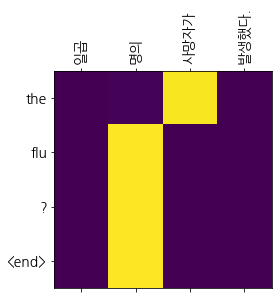

In [206]:
test_translate_tkn(test_sentences)

> mecab 으로 토큰화.  
> 기본 구성보다 더 엉망이다.

### 세번째 시도 - 길이 조정

오바마는 대통령이다
['오바마', '대통령', '다']
[[301, 81, 1]]
(1, 12) [[301  81   1   0   0   0   0   0   0   0   0   0]]
Input: 오바마는 대통령이다.
Predicted translation: songdo to host g prep meetin . . . <end> 


/tmp/ipykernel_37/3492739089.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_37/3492739089.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


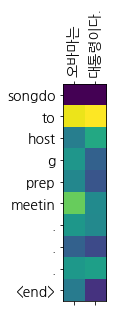

시민들은 도시 속에 산다
['시민', '도시', '속', '산다']
[[1120, 323, 420]]
(1, 12) [[1120  323  420    0    0    0    0    0    0    0    0    0]]
Input: 시민들은 도시 속에 산다.
Predicted translation: the dow is not sold to go . <end> 


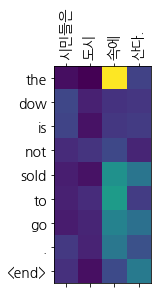

커피는 필요 없다
['커피', '필요', '없', '다']
[[1294, 219, 32, 1]]
(1, 12) [[1294  219   32    1    0    0    0    0    0    0    0    0]]
Input: 커피는 필요 없다.
Predicted translation: flakey forecasters promise cash . . . <end> 


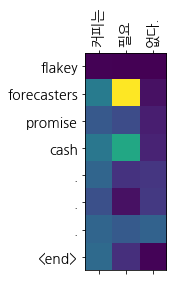

일곱 명의 사망자가 발생했다
['일곱', '명', '사망자', '발생', '했', '다']
[[6992, 15, 360, 122, 3, 1]]
(1, 12) [[6992   15  360  122    3    1    0    0    0    0    0    0]]
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ban will thwart civil servants . . . <end> 


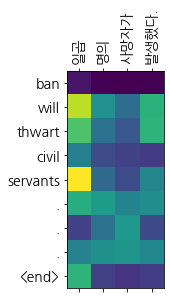

In [244]:
test_translate_tkn(test_sentences)

> mecab 토큰화  
> 길이 1 미만 토큰 제거: 하나의 단어로 이루어진 문장들이, 그것도 중복된 데이터들이 많았다. 제거.  
> 번역은 여전히 형편없지만, 두번째 시도처럼 이상한 결과는 보이지 않는다.  

### 네번째 시도 - 잘못된 전처리 수정

오바마는 대통령이다
['오바마', '대통령', '다']
[[157, 110, 1]]
(1, 21) [[157 110   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]]
Input: 오바마는 대통령이다.
Predicted translation: the government of the first house . <end> 


/tmp/ipykernel_37/3492739089.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_37/3492739089.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


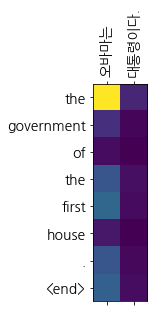

시민들은 도시 속에 산다
['시민', '도시', '속', '산다']
[[1174, 330, 612]]
(1, 21) [[1174  330  612    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
Input: 시민들은 도시 속에 산다.
Predicted translation: the ap s been been been been been been been been been been been been been been been been been been been been been been been been been been been been been been been 


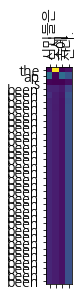

커피는 필요 없다
['커피', '필요', '없', '다']
[[1482, 300, 93, 1]]
(1, 21) [[1482  300   93    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
Input: 커피는 필요 없다.
Predicted translation: but the united states . <end> 


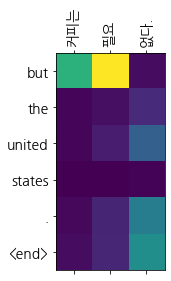

일곱 명의 사망자가 발생했다
['일곱', '명', '사망자', '발생', '했', '다']
[[6559, 18, 414, 189, 4, 1]]
(1, 21) [[6559   18  414  189    4    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two states . <end> 


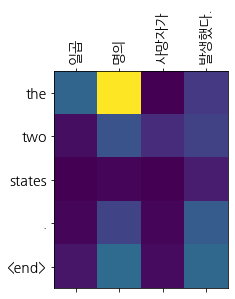

In [49]:
test_translate_tkn(test_sentences)

> 잘못된 전처리 수정  
> 더 나은 결과를 기대했으나, 형편없는 결과가 나온다.  

### 다섯번째 시도 - 추가 학습

오바마는 대통령이다
['오바마', '대통령', '다']
[[157, 110, 1]]
(1, 21) [[157 110   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]]
Input: 오바마는 대통령이다.
Predicted translation: obama s . <end> 


/tmp/ipykernel_37/3492739089.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_37/3492739089.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


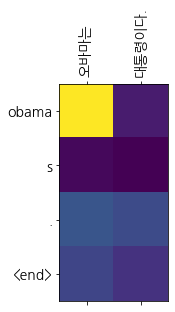

시민들은 도시 속에 산다
['시민', '도시', '속', '산다']
[[1174, 330, 612]]
(1, 21) [[1174  330  612    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
Input: 시민들은 도시 속에 산다.
Predicted translation: the unemployment of the ventilator in the ventilator in the ventilator in the ventilator in the ventilator in the ventilator in the ventilator in the ventilator in the ventilator in the ventilator in the 


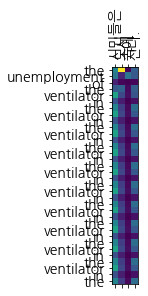

커피는 필요 없다
['커피', '필요', '없', '다']
[[1482, 300, 93, 1]]
(1, 21) [[1482  300   93    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
Input: 커피는 필요 없다.
Predicted translation: but the coffee is a lot of the coffee is a lot of the coffee is a lot of the coffee is a lot of the coffee is a lot of the coffee is 


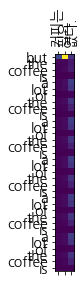

일곱 명의 사망자가 발생했다
['일곱', '명', '사망자', '발생', '했', '다']
[[6559, 18, 414, 189, 4, 1]]
(1, 21) [[6559   18  414  189    4    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the ministry said . <end> 


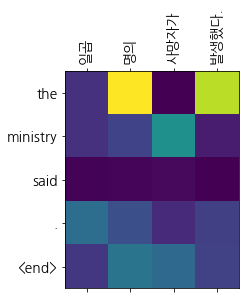

In [66]:
test_translate_tkn(test_sentences)

> 10 epoch 더 학습  
> 아.... 왜 이러는걸까...   

### 여섯번째 시도 - word2vec embedding

오바마는 대통령이다
['오바마', '대통령', '다']
[[157, 110, 1]]
(1, 21) [[157 110   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]]
Input: 오바마는 대통령이다.
Predicted translation: the president roh moo hyun s a president bush s a president bush s a president bush s a president bush s a president bush s a president bush s a president bush s 


/tmp/ipykernel_37/3492739089.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_37/3492739089.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


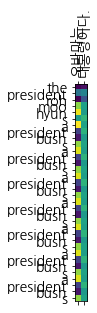

시민들은 도시 속에 산다
['시민', '도시', '속', '산다']
[[1174, 330, 612]]
(1, 21) [[1174  330  612    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
Input: 시민들은 도시 속에 산다.
Predicted translation: the couple of the way . <end> 


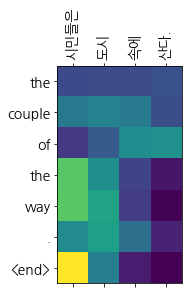

커피는 필요 없다
['커피', '필요', '없', '다']
[[1482, 300, 93, 1]]
(1, 21) [[1482  300   93    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
Input: 커피는 필요 없다.
Predicted translation: the baby is a little thing . <end> 


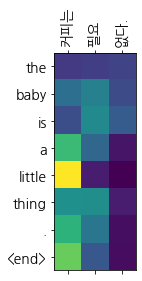

일곱 명의 사망자가 발생했다
['일곱', '명', '사망자', '발생', '했', '다']
[[6559, 18, 414, 189, 4, 1]]
(1, 21) [[6559   18  414  189    4    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the police said . <end> 


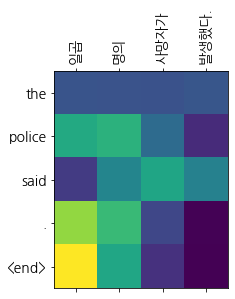

In [188]:
test_translate_tkn(test_sentences)

> 이것 역시 결과 형편없긴 한데, 웃기다.  
> '대통령'이 나왔다고, the president roh moo hyun s a president bush  
> 나머지 번역들은 엉뚱하다.

> 